In [1]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
import statsmodels.api as sm
from liftover import get_lifter
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics, sv_plot

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%reload_ext autoreload
%autoreload 2

# MYCN and 16p Neuroblastoma

Similar to EWSR1-FLI1, MYCN is somatically amplified in a subset of neuroblastoma (although its prevalence is significantly lower than Ewing's).

The logic here is that perhaps there is something similar happening. There are a few literature notable cases in this context. In particular, there's this paper: https://pubmed.ncbi.nlm.nih.gov/31474320/. Which implicates both a MYCN (chr2) amplification and a 16p11 deletion. We'll take a look at these loci.

__Note:__ The paper listed above actually collapsed large CNVs. We'll need to think about whether that is necessary here.

# Load in SVs and samples

In [2]:
svs = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v1.1.validation_cohort.analysis_samples.wAFs.bed.gz",
    sep="\t",
)
dosages = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v1.1.validation_cohort.analysis_samples.wAFs.allele_dosages.bed.gz",
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (19,20,21,23,25,27,31,32,33,34,48,49,63,64,82,83,89,98,99,113,114,132,133,138,147,148,162,163,181,182,187,196,197,211,212,230,231,245,246,260,261,279,280,285,294,295,309,310,328,329,336,345,346,351,360,361,375,376,381,390,391,398,407,408,413,422,423,428,437,438,443,452,453,460,469,470,475,484,485,490,499,500,505,514,515,522,531,532,537,546,547,552,561,562,567,576,577,584,593,594,599,608,609,623,624,629,638,639,646,655,656,661,670,671,676,685,686,700,701,707,713,719,725,731) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [84]:
metadata = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/gatk_sv_pediatric_cancers_combined_cohort_metadata_3_31_23.w_control_assignments.txt",
    sep="\t",
)
validation_samples = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v1.validation_cohort_final_samples.list",
    header=None,
)[0].to_list()

# extract out the samples prsent in the dosage matrix
nbl_samples = metadata[metadata["disease"] == "neuroblastoma"]["entity:sample_id"].to_list()
nbl_samples = sorted(set(validation_samples) & set(nbl_samples))

control_samples = metadata[metadata["neuroblastoma_control"]]["entity:sample_id"].to_list()
control_samples = sorted(set(validation_samples) & set(control_samples))

# create a new sex column for modeling, XY = 1
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

len(nbl_samples), len(control_samples)

(529, 2098)

# Identifying regions of interest

Unlike EWSR1-FLI1, we aren't simply looking at genes here. The germline amplification noted in that paper is incredibly large, as large as 10 Mb. Similarly, the noted microdeletion on 16p is nearly 10 Mb in size.

This is tricky because I don't know how GATK handles CNVs--I assume it uses read depth, in which case these events should easily span MYCN and a narrow region on 16p, but we'll cast a large net either way.

Luckily, this paper did us a favor and categorized their large CNVs:

In [29]:
large_nbl_cnvs = pd.read_excel('ref/10.1016-j.ajhg.2019.07.020-supplementary/1-s2.0-S0002929719303039-mmc2.xlsx', skiprows=3)
large_nbl_cnvs['start'] = large_nbl_cnvs['Region'].apply(lambda region: region.split(':')[1].split('-')[0].replace(',', '')).astype(int)
large_nbl_cnvs['end'] = large_nbl_cnvs['Region'].apply(lambda region: region.split(':')[1].split('-')[1].replace(',', '')).astype(int)
large_nbl_cnvs['chrom'] = large_nbl_cnvs['Region'].apply(lambda region: region.split(':')[0])

We'll be taking a look at two: `chr16:p11.2` and `chr2:p25.1-p24.2`. MYCN is located on `chr2:16,080,672-16,087,126`, or `2p24.3`. The chr16 microdeletion has variable location, but it looks as though it primarily appears around 30 Mb along chr16.

## MYCN

Some digging around in this dataset shows that there actually isn't a reproducible MYCN amplification. Only one sample has one in the paper, and that sample is apparently not given in this dataset.

In [30]:
large_nbl_cnvs.query('chrom == "chr2" & start > 1200000').sort_values(by = 'start').iloc[5:10]

,Chip Barcode,USIa,Group,Region,Event,Length,Cytoband,Probe Median,Probe Count,Minimum Size,Minimum Region,Maximum Size,Maximum Region,Call P-value,start,end,chrom
102,1562857594_A,PAKHSL,Discovery Cohort Case,"chr2:4,114,403-4,651,344",CN Loss,536942,p25.3 - p25.2,-0.636486,74,526241,"chr2:4,124,656-4,650,896",547642,"chr2:4,104,151-4,651,792",3.970000e-140,4114403,4651344,chr2
3190,6205470038_R03C01,Control,Replication Cohort Control,"chr2:30,702,846-32,771,540",CN Gain,2068695,p23.1 - p22.3,0.215332,430,2063126,"chr2:30,703,971-32,767,096",2074263,"chr2:30,701,722-32,775,984",8.800000e-241,30702846,32771540,chr2
2917,6092196190_R06C02,Control,Replication Cohort Control,"chr2:32,019,597-33,071,570",CN Gain,1051974,p23.1 - p22.3,0.194516,123,1042433,"chr2:32,020,049-33,062,481",1061514,"chr2:32,019,146-33,080,659",4.850000e-32,32019597,33071570,chr2
1299,4067202054_B,Control,Discovery Cohort Control,"chr2:32,521,450-33,322,967",CN Gain,801518,p22.3,0.255594,112,780624,"chr2:32,540,334-33,320,957",822413,"chr2:32,502,566-33,324,978",6.730000e-42,32521450,33322967,chr2
3951,7930622149_R05C02,Control,Replication Cohort Control,"chr2:32,538,503-33,340,399",CN Gain,801897,p22.3,0.227224,134,798189,"chr2:32,541,438-33,339,626",805605,"chr2:32,535,568-33,341,172",1.480000e-55,32538503,33340399,chr2


We can see that the given CNVs jump from 4 Mb to 30 Mb, essentially skipping MYCN.

## 16p microdeletion

This one is a little harder to wrangle, since we don't have exact genomic coordinates.

In [36]:
nbl_16p_microdel = large_nbl_cnvs[(large_nbl_cnvs['chrom'] == 'chr16') &
                                  (large_nbl_cnvs['Cytoband'] == 'p11.2')]
nbl_16p_microdel.shape

(47, 17)

In [45]:
nbl_16p_microdel.head(2)

,Chip Barcode,USIa,Group,Region,Event,Length,Cytoband,Probe Median,Probe Count,Minimum Size,Minimum Region,Maximum Size,Maximum Region,Call P-value,start,end,chrom
42,1552042589_A,PANWZA,Discovery Cohort Case,"chr16:29,529,922-30,270,939",CN Loss,741018,p11.2,-0.526034,36,530466,"chr16:29,647,342-30,177,807",951569,"chr16:29,412,503-30,364,071",1.060000e-94,29529922,30270939,chr16
63,1557556242_A,PAMXAW,Discovery Cohort Case,"chr16:29,529,922-30,270,939",CN Gain,741018,p11.2,0.241063,36,530466,"chr16:29,647,342-30,177,807",951569,"chr16:29,412,503-30,364,071",4.540000e-12,29529922,30270939,chr16


Some digging into this and the paper suggests that the "critical region" is `chr16:29,529,922-30,270,939`. This is the region that we'll define.

Unfortunately, we do need to lift this region over, as it was defined by this paper that used hg19.

In [48]:
# do the liftover
hg19_to_hg38 = get_lifter("hg19", "hg38")
hg19_to_hg38.query('chr16', 29529922), hg19_to_hg38.query('chr16', 30270939)


([('chr16', 29518601, '+')], [('chr16', 30259618, '+')])

So `chr16:295186010-30259618`

In [55]:
genes = {
    "MYCN": ["chr2", 15940550, 15947007],
    "16pmicrodel": ["chr16", 29518601, 30259618],
}

gene_locs = pd.DataFrame.from_dict(
    genes, orient="index", columns=["chrom", "start", "end"]
)
gene_locs["gene"] = genes.keys()

In [56]:
gene_locs

,chrom,start,end,gene
MYCN,chr2,15940550,15947007,MYCN
16pmicrodel,chr16,29518601,30259618,16pmicrodel


# Isolate the SVs in this region

In [57]:
# get 0.5 Mb on either side of the gene
window_size = 1e6

# expand the gene "locations" to include this window
expanded_gene_locs = gene_locs.copy()
expanded_gene_locs["start"] = (expanded_gene_locs["start"] - window_size / 2).astype(
    int
)
expanded_gene_locs["end"] = (expanded_gene_locs["end"] + window_size / 2).astype(int)

# do the intersection with pybedtools. pybedtools requires either a temp file or
# a string, and we choose the latter.
expanded_gene_bed = pybedtools.BedTool(
    expanded_gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
)
sv_bed = pybedtools.BedTool(
    svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

svs_in_regions = sv_bed.intersect(expanded_gene_bed, wo=True)
svs_in_regions = svs_in_regions.to_dataframe()

# drop unnecessary columns
svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]

In [58]:
svs_in_regions

,chrom,start,end,name,gene
0,chr2,15443841,15443892,All_20_Batches.chr2.final_cleanup_INS_chr2_343,MYCN
1,chr2,15453979,15455198,All_20_Batches.chr2.final_cleanup_DUP_chr2_523,MYCN
2,chr2,15463104,15465416,All_20_Batches.chr2.final_cleanup_DEL_chr2_1106,MYCN
3,chr2,15481484,15481611,All_20_Batches.chr2.final_cleanup_DEL_chr2_1107,MYCN
4,chr2,15488285,16373814,All_20_Batches.chr2.final_cleanup_DUP_chr2_524,MYCN
...,...,...,...,...,...
352,chr16,30725250,30725312,All_20_Batches.chr16.final_cleanup_DUP_chr16_1201,16pmicrodel
353,chr16,30744486,30750487,All_20_Batches.chr16.final_cleanup_DUP_chr16_1203,16pmicrodel
354,chr16,30748321,30749044,All_20_Batches.chr16.final_cleanup_DEL_chr16_2142,16pmicrodel
355,chr16,30749020,30749182,All_20_Batches.chr16.final_cleanup_DEL_chr16_2143,16pmicrodel


We "quickly" nab complex SVs as well

In [59]:
# get all complex SVs
complex_svs = svs[(svs["svtype"] == "CPX")][
    [
        "name",
        "#chrom",
        "start",
        "end",
        "svtype",
        "CHR2",
        "CPX_INTERVALS",
        "CPX_TYPE",
        "END",
    ]
].copy()

# split each component SV--represented by CPX_INTERVALS--into their own rows
complex_svs = complex_svs.assign(
    intervals=complex_svs["CPX_INTERVALS"].str.split(",")
).explode("intervals")

# convert this data to a proper bed for intersection
complex_sv_bed = complex_svs[["name", "intervals"]].copy()
complex_sv_bed["chrom"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[0].split("_")[-1]
)
complex_sv_bed["start"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[0]
)
complex_sv_bed["end"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[1]
)

# convert to a bedtool
complex_sv_bed = pybedtools.BedTool(
    complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
        sep="\t", index=False, header=False
    ),
    from_string=True,
)

# do our intersection
complex_svs_in_regions = complex_sv_bed.intersect(expanded_gene_bed, wo=True)

complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

# drop unnecessary columns
if len(complex_svs_in_regions):
    complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
    complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
else:
    complex_svs_in_regions = pd.DataFrame(
        columns=["chrom", "start", "end", "name", "gene"]
    )

In [60]:
complex_svs_in_regions

,chrom,start,end,name,gene
0,chr2,15796015,15930622,All_20_Batches.chr2.final_cleanup_CPX_chr2_34,MYCN
1,chr2,15930622,16087855,All_20_Batches.chr2.final_cleanup_CPX_chr2_34,MYCN
2,chr2,16087855,16415986,All_20_Batches.chr2.final_cleanup_CPX_chr2_34,MYCN
3,chr2,15930622,15930835,All_20_Batches.chr2.final_cleanup_CPX_chr2_35,MYCN
4,chr2,15930622,16415986,All_20_Batches.chr2.final_cleanup_CPX_chr2_35,MYCN
5,chr2,16079849,16081075,All_20_Batches.chr2.final_cleanup_CPX_chr2_36,MYCN
6,chr2,16080529,16081075,All_20_Batches.chr2.final_cleanup_CPX_chr2_36,MYCN
7,chr16,29108850,29109031,All_20_Batches.chr5.final_cleanup_CPX_chr5_198,16pmicrodel
8,chr16,29226774,29226840,All_20_Batches.chr16.final_cleanup_CPX_chr16_59,16pmicrodel
9,chr16,29226774,29227265,All_20_Batches.chr16.final_cleanup_CPX_chr16_59,16pmicrodel


In [61]:
# the number of complex SVs recovered, and the number that were in our original simple overlap
len(set(complex_svs_in_regions["name"])), len(
    set(complex_svs_in_regions["name"]) & set(svs_in_regions["name"])
)

(6, 5)

In [63]:
svs[svs["name"].isin(complex_svs_in_regions["name"])]

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,HIGH_SR_BACKGROUND,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SOURCE,STRANDS,SVLEN,SVTYPE,UNRESOLVED_TYPE,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,...,SAS_neuroblastoma_CN_NUMBER,SAS_neuroblastoma_CN_COUNT,SAS_neuroblastoma_CN_FREQ,SAS_neuroblastoma_CN_NONDIPLOID_COUNT,SAS_neuroblastoma_CN_NONDIPLOID_FREQ,SAS_osteosarcoma_AN,SAS_osteosarcoma_AC,SAS_osteosarcoma_AF,SAS_osteosarcoma_N_BI_GENOS,SAS_osteosarcoma_N_HOMREF,SAS_osteosarcoma_N_HET,SAS_osteosarcoma_N_HOMALT,SAS_osteosarcoma_FREQ_HOMREF,SAS_osteosarcoma_FREQ_HET,SAS_osteosarcoma_FREQ_HOMALT,SAS_osteosarcoma_CN_NUMBER,SAS_osteosarcoma_CN_COUNT,SAS_osteosarcoma_CN_FREQ,SAS_osteosarcoma_CN_NONDIPLOID_COUNT,SAS_osteosarcoma_CN_NONDIPLOID_FREQ,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONDIPLOID_FREQ,POPMAX_control_AF,POPMAX_control_FREQ_HOMREF,POPMAX_control_FREQ_HET,POPMAX_control_FREQ_HOMALT,POPMAX_control_CN_FREQ,POPMAX_control_CN_NONDIPLOID_FREQ,POPMAX_ewing_AF,POPMAX_ewing_FREQ_HOMREF,POPMAX_ewing_FREQ_HET,POPMAX_ewing_FREQ_HOMALT,POPMAX_ewing_CN_FREQ,POPMAX_ewing_CN_NONDIPLOID_FREQ,POPMAX_neuroblastoma_AF,POPMAX_neuroblastoma_FREQ_HOMREF,POPMAX_neuroblastoma_FREQ_HET,POPMAX_neuroblastoma_FREQ_HOMALT,POPMAX_neuroblastoma_CN_FREQ,POPMAX_neuroblastoma_CN_NONDIPLOID_FREQ,POPMAX_osteosarcoma_AF,POPMAX_osteosarcoma_FREQ_HOMREF,POPMAX_osteosarcoma_FREQ_HET,POPMAX_osteosarcoma_FREQ_HOMALT,POPMAX_osteosarcoma_CN_FREQ,POPMAX_osteosarcoma_CN_NONDIPLOID_FREQ,FILTER
24400,chr2,15796014,16415986,All_20_Batches.chr2.final_cleanup_CPX_chr2_34,CPX,1,0.000140,manta,7162,False,chr2,"DEL_chr2:15796015-15930622,INV_chr2:15930622-1...",delINVdel,16415986,NaN,"PE,SR",False,0.0,False,NaN,NaN,NaN,False,NaN,NaN,MYCN,NaN,NaN,NaN,ewing_chromHMM15_Enh,"UCNE_conserved,ewing_ABC_MAX_enhancer,ewing_AB...",NaN,NaN,NaN,NaN,NaN,NaN,619971,CPX,POSTHOC_RD_GT_REJECTION,3581.0,3580.0,1.0,0.0,0.999721,0.000279,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.002584,0.00000,NaN,NaN,0.000000,1.0,0.000000,0.000000,NaN,NaN,0.000000,1.000000,0.0,0.000000,NaN,NaN,0.012820,1.000000,0.025641,0.000000,NaN,NaN,0.000000,1.000000,0.000000,0.000000,NaN,NaN,UNRESOLVED
24408,chr2,15930621,16415986,All_20_Batches.chr2.final_cleanup_CPX_chr2_35,CPX,1,0.000140,manta,7162,True,chr2,"DUP_chr2:15930622-15930835,INV_chr2:15930622-1...",dupINV,16415986,NaN,SR,False,0.0,False,NaN,NaN,NaN,False,NaN,NaN,MYCN,NaN,NaN,NaN,NaN,"UCNE_conserved,ewing_H3K27Ac_peak,ewing_and_os...",NaN,NaN,NaN,NaN,NaN,NaN,485364,CPX,NaN,3581.0,3580.0,1.0,0.0,0.999721,0.000279,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.002584,0.00000,NaN,NaN,0.000000,1.0,0.000000,0.000000,NaN,NaN,0.000000,1.000000,0.0,0.000000,NaN,NaN,0.012820,1.000000,0.025641,0.000000,NaN,NaN,0.000000,1.000000,0.000000,0.000000,NaN,NaN,PASS
24427,chr2,16079848,16081075,All_20_Batches.chr2.final_cleanup_CPX_chr2_36,CPX,1,0.000140,manta,7162,False,chr2,"INV_chr2:16079849-16081075,DUP_chr2:16080529-1...",INVdup,16081075,NaN,"PE,SR",False,0.0,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,MYCN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1226,CPX,NaN,3581.0,3580.0,1.0,0.0,0.999721,0.000279,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.000351,0.00000,NaN,NaN,0.000299,1.0,0.000598,0.000000,NaN,NaN,0.000000,1.000000,0.0,0.000000,NaN,NaN,0.000000,1.000000,0.000000,0

Again, this process picks up only one new SV--a distributed duplication.

## Subsetting and QC'ing SVs in gene regions

To save memory, we subset the big SV and dosage matrices down to just these samples and SVs.

In [69]:
# keep the gene names
svs_in_regions_names = pd.concat(
    [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
)

In [70]:
len(svs_in_regions_names)

369

So a decent number of SVs in this dataset fall within this region. Briefly, Ryan and Riaz wanted to know if there are any MCNVs


In [71]:
svs[svs['name'].isin(svs_in_regions_names['name'])]['svtype'].value_counts()

DEL             180
DUP              85
BND              49
INS:ME:ALU       15
INS              12
CPX               7
INS:ME:SVA        6
CNV               2
INS:ME:LINE1      1
INV               1
Name: svtype, dtype: int64

So no. We fetch all these SVs from the original dataset now and apply some filters:

In [72]:
# subset
subset_svs = svs.set_index("name").loc[svs_in_regions_names["name"]].reset_index()
subset_svs.insert(0, "gene", svs_in_regions_names["gene"].values)

# how many are PASS?
print(subset_svs["FILTER"].value_counts())

# and how many are rare?
print("\nRare:\n", (subset_svs["AF"] < 0.01).value_counts())

PASS                                    294
UNRESOLVED                               49
HIGH_PCRMINUS_NOCALL_RATE                20
HIGH_PCRMINUS_NOCALL_RATE,UNRESOLVED      4
MULTIALLELIC                              2
Name: FILTER, dtype: int64

Rare:
 True     296
False     73
Name: AF, dtype: int64


That's not bad. How many pass the filter, are rare, and are present in the dosage matrix?

We'll add in a quick QC method to remove some suspect SVs that Ryan is concerned about.

In [79]:
# only include SVs that pass the FILTER, are rare, and are in our dosage matrix
svs_to_keep = subset_svs[
    (
        (subset_svs["FILTER"] == "PASS")
        & (subset_svs["name"].isin(dosages["ID"].to_list()))
        & (~subset_svs["EVIDENCE"].isin(["BAF,RD", "RD"]))
        & (~(subset_svs["ALGORITHMS"] == "depth"))
    )
].copy()

svs_to_keep["rare"] = svs_to_keep["AF"] < 0.01

svs_to_keep.shape

(219, 736)

In [80]:
svs_to_keep["svtype"].value_counts()

DEL             146
DUP              25
INS:ME:ALU       15
CPX              14
INS              11
INS:ME:SVA        6
INS:ME:LINE1      1
INV               1
Name: svtype, dtype: int64

Text(0.5, 0, 'AF')

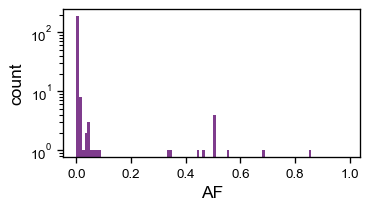

In [81]:
fig, ax = plt.subplots(1, figsize=(4, 2))
plt.hist(svs_to_keep["AF"], bins=np.arange(0, 1, 0.01))
plt.yscale("log")
plt.ylabel("count")
plt.xlabel("AF")

So there are some SVs in this region, and the vast majority are rare (unsurprisingly). We'll analyze them all together, but at some points keep rare separate.

## Extract sample dosages

Here we pull out the allele counts for each SV, so that we can determine case vs. control.

In [82]:
# we begin by subsetting the dosage matrix down to the SVs that we care about. This double counts SVs
# that affect more than one gene.
subset_dosages = dosages[dosages["ID"].isin(svs_to_keep["name"].to_list())].reset_index(
    drop=True
)

# we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
subsetted_gene_dosages = (
    svs_to_keep[["name", "gene", "AF", "rare"]]
    .merge(subset_dosages, right_on="ID", left_on="name")
    .iloc[1:]
)

subsetted_gene_dosages.head(2)

,name,gene,AF,rare,#chr,start,end,ID,PT_2AHXQP58,PT_GMGNDRBJ,PT_MEC48DAY,PT_N8PKC3YS,PT_VEMC27RN,SJ051090,SJ051119,SJ051140,SJ051197,SJ051210,SJ051231,SJ051244,SJ051246,SJ051259,SJ051263,SJ051267,SJ051298,SJ051299,SJ051310,SJ051322,SJ051329,SJ051336,SJ051367,SJ051390,SJ051391,SJ051392,SJ051416,SJ051439,SJ051485,SJ051531,SJ051539,SJ051566,SJ051574,SJ051610,SJ051653,SJ051655,SJ051662,SJ051672,SJ051679,SJ051694,SJ051705,SJ051713,...,SJ054333,SJ055976,SJ055977,SJ055980,SJ055992,SJ056005,SJ056011,SJ056035,SJ056044,SJ056062,SJ056068,SJ056156,SJ056241,SJ056250,SJ056312,SJ056317,SJ056321,SJ056360,SJ056374,SJ056381,SJ056446,SJ056468,SJ056480,SJ056503,SJ056509,SJ056535,SJ056833,SJ056855,SJ056862,SJ056888,SJ056891,SJ056916,SJ056922,SJ056924,SJ058208,SJ058211,SJ058213,SJ058220,SJ058227,SJ058233,SJ058237,SJ058252,SJ058253,SJ058283,SJ063819,SJ063829,SJ063834,SJ071780,SJ071781,ssi_11896
1,All_20_Batches.chr2.final_cleanup_DUP_chr2_523,MYCN,0.000140,True,chr2,15453980,15455198,All_20_Batches.chr2.final_cleanup_DUP_chr2_523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,All_20_Batches.chr2.final_cleanup_DEL_chr2_1106,MYCN,0.000279,True,chr2,15463105,15465416,All_20_Batches.chr2.final_cleanup_DEL_chr2_1106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we devise two metrics for cases and controls--one listing the allele frequency of each SV and another listing the number of samples with an SV in the gene.

We need to convert the dosage (allele count) to allele frequencies

In [85]:
case_control_counts = []
case_control_samples_with_svs = []

for sample_group, label in zip(
    [nbl_samples, control_samples], ["cases", "controls"]
):

    # subset to these samples
    sample_dosages = subsetted_gene_dosages[
        ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
    ]

    # first, count the SVs. This function counts the number of samples with each genotype.
    sv_counts = (
        sample_dosages[sample_group]
        .apply(lambda row: row.dropna().value_counts(), axis=1)
        .fillna(0)
        .astype(int)
    )

    # name columns to genotypes
    sv_counts.columns = f"{label}_" + sv_counts.columns.astype(int).astype(str)
    sv_counts["name"] = sample_dosages["name"]

    case_control_counts.append(sv_counts)

    # now count the number of samples with at least one SV around each gene.
    # we groupby gene, then determine whether each sample has an SV in that gene, then
    # count these samples up per gene.
    num_samples_with_svs = sample_dosages.groupby(["gene"]).apply(
        lambda group: (group[sample_group] > 0).any(axis=0).sum()
    )

    num_samples_with_svs.name = label + "_all"
    num_samples_with_svs = num_samples_with_svs / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs)

    # repeat for rare SVs
    num_samples_with_svs_rare = (
        sample_dosages.query("rare == True")
        .groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0).sum())
    )

    num_samples_with_svs_rare.name = label + "_rare"
    num_samples_with_svs_rare = num_samples_with_svs_rare / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs_rare)

# merge
case_control_sv_counts = sample_dosages.iloc[:, :7].reset_index(drop=True)
for df in case_control_counts:
    case_control_sv_counts = case_control_sv_counts.merge(df)

case_control_sv_counts["midpoint"] = np.mean(
    case_control_sv_counts[["start", "end"]], axis=1
)

# and total up the sample counts
case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T

In [86]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint
0,All_20_Batches.chr2.final_cleanup_DUP_chr2_523,MYCN,chr2,15453980,15455198,0.000140,True,529,0,0,2097,1,0,15454589.0
1,All_20_Batches.chr2.final_cleanup_DEL_chr2_1106,MYCN,chr2,15463105,15465416,0.000279,True,529,0,0,2096,2,0,15464260.5


Next we add some columns for allele frequency.

In [87]:
for label in ["cases", "controls"]:

    # a quick check to see if there are non-0/1/2 genotypes
    columns = [col for col in case_control_sv_counts.columns if col.startswith(label)]
    assert columns == [f"{label}_{i}" for i in range(3)]

    alt = (case_control_sv_counts[columns] * np.array([0, 1, 2])).sum(axis=1)
    ref = case_control_sv_counts[columns].sum(axis=1) * 2
    case_control_sv_counts[f"AF_{label}"] = alt / ref

In [88]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
0,All_20_Batches.chr2.final_cleanup_DUP_chr2_523,MYCN,chr2,15453980,15455198,0.000140,True,529,0,0,2097,1,0,15454589.0,0.0,0.000238
1,All_20_Batches.chr2.final_cleanup_DEL_chr2_1106,MYCN,chr2,15463105,15465416,0.000279,True,529,0,0,2096,2,0,15464260.5,0.0,0.000477


In [89]:
case_control_sample_counts

,cases_all,cases_rare,controls_all,controls_rare
gene,,,,
16pmicrodel,1.0,0.204159,1.0,0.153956
MYCN,1.0,0.117202,1.0,0.071020


Any smoking guns in terms of SVs?

In [91]:
freq_diff = case_control_sv_counts["AF_cases"] - (case_control_sv_counts["AF_controls"])

case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].head(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
102,All_20_Batches.chr2.final_cleanup_DUP_chr2_537,MYCN,chr2,16113712,16113862,0.553337,False,21,347,161,134,1846,118,16113787.0,0.632325,0.496187
128,All_20_Batches.chr2.final_cleanup_INS_chr2_363,MYCN,chr2,16395357,16395367,0.346272,False,90,438,1,790,1308,0,16395362.0,0.415879,0.311725
117,All_20_Batches.chr2.final_cleanup_DUP_chr2_541,MYCN,chr2,16225124,16226720,0.858699,False,0,134,395,0,621,1477,16225922.0,0.873346,0.852002
22,All_20_Batches.chr2.final_cleanup_DEL_chr2_1123,MYCN,chr2,15787705,15787796,0.043883,False,420,53,0,1892,146,0,15787750.5,0.056025,0.035819


In [92]:
case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].tail(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
104,All_20_Batches.chr2.final_cleanup_DEL_chr2_1145,MYCN,chr2,16131510,16133769,0.462937,False,111,361,55,343,1520,233,16132639.5,0.446869,0.473760
180,All_20_Batches.chr16.final_cleanup_DUP_chr16_1131,16pmicrodel,chr16,29238380,29238527,0.040233,False,502,23,0,1848,207,0,29238453.5,0.021905,0.050365
106,All_20_Batches.chr2.final_cleanup_DUP_chr2_540,MYCN,chr2,16143935,16143990,0.066043,False,512,16,1,1696,392,10,16143962.5,0.017013,0.098189
111,All_20_Batches.chr2.final_cleanup_DEL_chr2_1147,MYCN,chr2,16146439,16146505,0.508936,False,374,134,21,129,887,1082,16146472.0,0.166352,0.727121


## Where do these fall relative to gene regions?

Presumably, the closer they are to the gene, the more we expect them to matter. We'll just map them out on the gene locuses (I like to visualize first).

This is a little hamfisted, but we'll split by common SVs and then just rare.